In [1]:
from google.colab import drive;
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define folder path
folder_path = '/content/drive/MyDrive/Number_Plate'

# List files in the folder
files = os.listdir(folder_path)
print("Files in the folder:")
print(files)

Files in the folder:
['.DS_Store', 'dataset', 'anchors.py', 'ciou_loss.py', 'focal_loss.py', 'loss.py', 'wandb_config.py', 'dataset.py', '__pycache__', 'wandb', '.env', 'evaluation.py', 'utils.py', 'model.py', 'run.py', 'best_model_trial_0.pth', 'best_model_trial_1.pth', 'best_model_trial_2.pth', 'best_model_trial_3.pth', 'best_model_trial_4.pth', 'best_model_trial_5.pth', 'best_model_trial_6.pth', 'best_model_trial_7.pth', 'best_model_trial_8.pth', 'best_model_trial_9.pth', 'best_model_trial_11.pth', 'best_model_trial_12.pth', 'best_model_trial_13.pth', 'best_model_trial_14.pth', 'best_model_trial_15.pth']


In [5]:

import torch
import torch.nn as nn

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False)
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        scale = self.sigmoid(avg_out + max_out)
        x = x * scale
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out = torch.max(x, dim=1, keepdim=True)[0]
        spatial_att = torch.cat([avg_out, max_out], dim=1)
        scale = self.sigmoid(self.spatial_conv(spatial_att))
        x = x * scale
        return x

class CBAMBlock(nn.Module):
    def __init__(self, module, channels):
        super(CBAMBlock, self).__init__()
        self.module = module
        self.cbam = CBAM(channels)

    def forward(self, x):
        x = self.module(x)
        x = self.cbam(x)
        return x


In [6]:

import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
#from cbam import CBAMBlock

def change_the_predictor(model, num_desired_classes=2):
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_desired_classes)
    return model

def change_the_backbone(num_desired_classes=2):
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    cbam_backbone = []
    for layer in backbone:
        if isinstance(layer, nn.Sequential):
            children = list(layer.children())
            if len(children) > 0 and isinstance(children[-1], nn.Conv2d):
                out_channels = children[-1].out_channels
                cbam_backbone.append(CBAMBlock(layer, out_channels))
            else:
                cbam_backbone.append(layer)
        elif isinstance(layer, nn.Conv2d):
            cbam_backbone.append(CBAMBlock(layer, layer.out_channels))
        else:
            cbam_backbone.append(layer)
    backbone = nn.Sequential(*cbam_backbone)
    backbone.out_channels = 1280

    anchor_generator = AnchorGenerator(sizes=((128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    model = FasterRCNN(backbone,
                       num_classes=num_desired_classes,
                       rpn_anchor_generator=anchor_generator)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_desired_classes)
    return model


In [7]:
import torch
import torch.nn as nn

class SimplifiedFasterRCNN(torch.nn.Module):
    def __init__(self, backbone, transform, rpn):
        super(SimplifiedFasterRCNN, self).__init__()
        self.backbone = nn.Sequential(*backbone)
        self.transform = transform
        self.rpn = rpn

    def override_nr_rpn_to_return(self):
        return 100

    def forward(self, x_in):
        im_list,_ = self.transform(x_in)
        x = self.backbone(im_list.tensors)
        self.rpn.post_nms_top_n = self.override_nr_rpn_to_return
        x = self.rpn(im_list, x)
        print(len(x[0][0]))
        return x

In [8]:
import torch
from torch.utils.data import DataLoader, random_split

def split_data(dataset, batch_size):
    total_size = len(dataset)
    train_size = int(0.75 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def print_model_size(model):
    total_pars = 0
    for _n, _par in model.state_dict().items():
        total_pars += _par.numel()
    print(f"Total number of parameters: {total_pars}")
    return

In [10]:
import wandb
wandb.login(key="dadc5760c5180b0aa661c9e66b78c7e8af724486")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [14]:
import os
import torch
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
import torchvision.transforms.functional as TF

class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=(416, 416), augment=True):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.augment = augment
        self.image_files = []
        for fname in os.listdir(img_dir):
            if isinstance(fname, bytes):
                fname = fname.decode("utf-8")
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                self.image_files.append(os.path.join(img_dir, fname))
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        if isinstance(img_path, bytes):
            img_path = img_path.decode("utf-8")
        basename = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.label_dir, basename + ".txt")
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size
        targets = []
        if os.path.isfile(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    if isinstance(line, bytes):
                        line = line.decode("utf-8")
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    targets.append([class_id, x_center, y_center, width, height])
        else:
            targets = []
        if len(targets) > 0:
            targets = torch.tensor(targets, dtype=torch.float32)
        else:
            targets = torch.zeros((0, 5), dtype=torch.float32)
        if self.augment:
            if random.random() < 0.5:
                image = ImageOps.mirror(image)
                if targets.shape[0] > 0:
                    targets[:, 1] = 1.0 - targets[:, 1]
        new_w, new_h = self.img_size
        if (orig_width, orig_height) != (new_w, new_h):
            image = image.resize((new_w, new_h), resample=Image.BILINEAR)
        image_tensor = TF.to_tensor(image)
        return image_tensor, targets

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 416
BATCH_SIZE = 8
NUM_CLASSES = 1
EPOCHS = 50
LEARNING_RATE = 1e-4
TRAIN_IMG_DIR = "/content/drive/MyDrive/Number_Plate/dataset/train/images"
TRAIN_LABEL_DIR = "/content/drive/MyDrive/Number_Plate/dataset/train/labels"
VAL_IMG_DIR = "/content/drive/MyDrive/Number_Plate/dataset/val/images"
VAL_LABEL_DIR = "/content/drive/MyDrive/Number_Plate/dataset/val/labels"
CHECKPOINT_PATH = "checkpoint.pth"

def yolo_collate_fn(batch):
    images = []
    targets_list = []
    for img, tgt in batch:
        images.append(img)
        targets_list.append(tgt)
    images = torch.stack(images, dim=0)
    return images, targets_list

train_dataset = YOLODataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, img_size=(IMAGE_SIZE, IMAGE_SIZE), augment=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=yolo_collate_fn)

val_dataset = YOLODataset(VAL_IMG_DIR, VAL_LABEL_DIR, img_size=(IMAGE_SIZE, IMAGE_SIZE), augment=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=yolo_collate_fn)


In [22]:
import os
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
#from frcnn_cbam_setup import change_the_backbone
#from utils import print_model_size
#from dataset import YOLODataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 416
BATCH_SIZE = 8
NUM_CLASSES = 1
EPOCHS = 50
LEARNING_RATE = 1e-4
TRAIN_IMG_DIR = "/content/drive/MyDrive/Number_Plate/dataset/train/images"
TRAIN_LABEL_DIR = "/content/drive/MyDrive/Number_Plate/dataset/train/labels"
VAL_IMG_DIR = "/content/drive/MyDrive/Number_Plate/dataset/val/images"
VAL_LABEL_DIR = "/content/drive/MyDrive/Number_Plate/dataset/val/labels"
CHECKPOINT_PATH = "checkpoint.pth"

def yolo_collate_fn(batch):
    images = []
    targets_list = []
    for img, tgt in batch:
        images.append(img)
        targets_list.append(tgt)
    images = torch.stack(images, dim=0)
    return images, targets_list

def convert_yolo_to_frcnn_targets(yolo_targets, image_size):
    frcnn_targets = []
    _, H, W = image_size
    for sample in yolo_targets:
        boxes = []
        labels = []
        for obj in sample:
            if isinstance(obj, bytes):
                obj = obj.decode("utf-8")
            class_id, x_c, y_c, w, h = obj.tolist()
            x1 = (x_c - w / 2) * W
            y1 = (y_c - h / 2) * H
            x2 = (x_c + w / 2) * W
            y2 = (y_c + h / 2) * H
            boxes.append([x1, y1, x2, y2])
            labels.append(int(class_id))
        target = {
            'boxes': torch.tensor(boxes).float().to(DEVICE),
            'labels': torch.tensor(labels).long().to(DEVICE)
        }
        frcnn_targets.append(target)
    return frcnn_targets

def train_loop(nr_epochs, model, train_dataloader, val_dataloader, optimizer):
    min_loss = float('inf')
    for epoch in range(nr_epochs):
        model.train()
        epoch_loss = 0
        for images, targets in train_dataloader:
            images = list(img.to(DEVICE) for img in images)
            frcnn_targets = convert_yolo_to_frcnn_targets(targets, images[0].shape)

            optimizer.zero_grad()
            loss_dict = model(images, frcnn_targets)
            total_loss = sum(loss for loss in loss_dict.values())
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        epoch_loss /= len(train_dataloader)
        if epoch_loss < min_loss:
            torch.save(model.state_dict(), CHECKPOINT_PATH)
            min_loss = epoch_loss

            artifact = wandb.Artifact("frcnn_cbam_best", type="model")
            artifact.add_file(CHECKPOINT_PATH)
            wandb.log_artifact(artifact)

        wandb.log({"train_loss": epoch_loss, "epoch": epoch})
        print(f"Epoch {epoch} | Train Loss: {epoch_loss:.4f}")
        evaluate(model, val_dataloader, epoch)

def evaluate(model, dataloader, epoch):
    model.eval()
    total_iou = 0
    count = 0
    # logged_images = []
    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            images = list(img.to(DEVICE) for img in images)
            frcnn_targets = convert_yolo_to_frcnn_targets(targets, images[0].shape)
            outputs = model(images)

            for j, (output, target, img_tensor) in enumerate(zip(outputs, frcnn_targets, images)):
                if len(output['boxes']) > 0 and len(target['boxes']) > 0:
                    ious = box_iou(output['boxes'], target['boxes'])
                    total_iou += ious.max(dim=1)[0].mean().item()
                    count += 1

    avg_iou = total_iou / count if count > 0 else 0
    wandb.log({"val_mIoU": avg_iou, "epoch": epoch})
    print(f"Validation mIoU: {avg_iou:.4f}")

def main():
    wandb.init(
        project="cbam_frcnn_project",
        name="cbam_frcnn_training",
        config={
            "image_size": IMAGE_SIZE,
            "batch_size": BATCH_SIZE,
            "num_classes": NUM_CLASSES,
            "epochs": EPOCHS,
            "lr": LEARNING_RATE,
        }
    )

    model = change_the_backbone(num_desired_classes=NUM_CLASSES + 1)
    model.to(DEVICE)

    train_dataset = YOLODataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, img_size=(IMAGE_SIZE, IMAGE_SIZE), augment=True)
    val_dataset = YOLODataset(VAL_IMG_DIR, VAL_LABEL_DIR, img_size=(IMAGE_SIZE, IMAGE_SIZE), augment=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=yolo_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=yolo_collate_fn)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    train_loop(
        nr_epochs=EPOCHS,
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer
    )

    print_model_size(model)
    print("Training complete.")

if __name__ == '__main__':
    main()


Epoch 0 | Train Loss: 0.1062
Validation mIoU: 0.0071
Epoch 1 | Train Loss: 0.0353
Validation mIoU: 0.0000
Epoch 2 | Train Loss: 0.0264
Validation mIoU: 0.0000
Epoch 3 | Train Loss: 0.0220
Validation mIoU: 0.0000
Epoch 4 | Train Loss: 0.0191
Validation mIoU: 0.0000
Epoch 5 | Train Loss: 0.0162
Validation mIoU: 0.0000
Epoch 6 | Train Loss: 0.0133
Validation mIoU: 0.0000
Epoch 7 | Train Loss: 0.0131
Validation mIoU: 0.0000
Epoch 8 | Train Loss: 0.0122
Validation mIoU: 0.0000
Epoch 9 | Train Loss: 0.0127
Validation mIoU: 0.0000
Epoch 10 | Train Loss: 0.0124
Validation mIoU: 0.0000
Epoch 11 | Train Loss: 0.0113
Validation mIoU: 0.0000
Epoch 12 | Train Loss: 0.0122
Validation mIoU: 0.0000
Epoch 13 | Train Loss: 0.0122
Validation mIoU: 0.0000
Epoch 14 | Train Loss: 0.0102
Validation mIoU: 0.0000
Epoch 15 | Train Loss: 0.0086
Validation mIoU: 0.0000
Epoch 16 | Train Loss: 0.0082
Validation mIoU: 0.0000
Epoch 17 | Train Loss: 0.0068
Validation mIoU: 0.0000
Epoch 18 | Train Loss: 0.0082
Validati

In [25]:
import os
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchmetrics.detection.mean_ap import MeanAveragePrecision
#from frcnn_cbam_setup import change_the_backbone
#from utils import print_model_size
#from dataset import YOLODataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 416
BATCH_SIZE = 8
NUM_CLASSES = 1
EPOCHS = 50
LEARNING_RATE = 1e-4
TRAIN_IMG_DIR = "/content/drive/MyDrive/Number_Plate/dataset/train/images"
TRAIN_LABEL_DIR = "/content/drive/MyDrive/Number_Plate/dataset/train/labels"
VAL_IMG_DIR = "/content/drive/MyDrive/Number_Plate/dataset/val/images"
VAL_LABEL_DIR = "/content/drive/MyDrive/Number_Plate/dataset/val/labels"
CHECKPOINT_PATH = "checkpoint.pth"

def yolo_collate_fn(batch):
    images = []
    targets_list = []
    for img, tgt in batch:
        images.append(img)
        targets_list.append(tgt)
    images = torch.stack(images, dim=0)
    return images, targets_list

def convert_yolo_to_frcnn_targets(yolo_targets, image_size):
    frcnn_targets = []
    _, H, W = image_size
    for sample in yolo_targets:
        boxes = []
        labels = []
        for obj in sample:
            if isinstance(obj, bytes):
                obj = obj.decode("utf-8")
            class_id, x_c, y_c, w, h = obj.tolist()
            x1 = (x_c - w / 2) * W
            y1 = (y_c - h / 2) * H
            x2 = (x_c + w / 2) * W
            y2 = (y_c + h / 2) * H
            boxes.append([x1, y1, x2, y2])
            labels.append(int(class_id))
        target = {
            'boxes': torch.tensor(boxes).float().to(DEVICE),
            'labels': torch.tensor(labels).long().to(DEVICE)
        }
        frcnn_targets.append(target)
    return frcnn_targets

def train_loop(nr_epochs, model, train_dataloader, val_dataloader, optimizer):
    min_loss = float('inf')
    for epoch in range(nr_epochs):
        model.train()
        epoch_loss = 0
        for images, targets in train_dataloader:
            images = list(img.to(DEVICE) for img in images)
            frcnn_targets = convert_yolo_to_frcnn_targets(targets, images[0].shape)

            optimizer.zero_grad()
            loss_dict = model(images, frcnn_targets)
            total_loss = sum(loss for loss in loss_dict.values())
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        epoch_loss /= len(train_dataloader)
        if epoch_loss < min_loss:
            torch.save(model.state_dict(), CHECKPOINT_PATH)
            min_loss = epoch_loss

            artifact = wandb.Artifact("frcnn_cbam_best", type="model")
            artifact.add_file(CHECKPOINT_PATH)
            wandb.log_artifact(artifact)

        wandb.log({"train_loss": epoch_loss, "epoch": epoch})
        print(f"Epoch {epoch} | Train Loss: {epoch_loss:.4f}")
        evaluate(model, val_dataloader, epoch)

def evaluate(model, dataloader, epoch):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])

    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            images = list(img.to(DEVICE) for img in images)
            frcnn_targets = convert_yolo_to_frcnn_targets(targets, images[0].shape)
            outputs = model(images)

            for output, target in zip(outputs, frcnn_targets):
                pred = {
                    "boxes": output["boxes"].cpu(),
                    "scores": output["scores"].cpu(),
                    "labels": output["labels"].cpu()
                }
                target_metric = {
                    "boxes": target["boxes"].cpu(),
                    "labels": target["labels"].cpu()
                }
                metric.update([pred], [target_metric])

    results = metric.compute()
    wandb.log({
        "mAP@0.5": results["map_50"],
        "Precision": results["map"],
        "Recall": results["mar_100"],
        "epoch": epoch
    })
    print(f"Validation mAP@0.5: {results['map_50']:.4f} | Precision: {results['map']:.4f} | Recall: {results['mar_100']:.4f}")

def main():
    wandb.init(
        project="cbam_frcnn_project_new",
        name="cbam_frcnn_training",
        config={
            "image_size": IMAGE_SIZE,
            "batch_size": BATCH_SIZE,
            "num_classes": NUM_CLASSES,
            "epochs": EPOCHS,
            "lr": LEARNING_RATE,
        }
    )

    model = change_the_backbone(num_desired_classes=NUM_CLASSES + 1)
    model.to(DEVICE)

    train_dataset = YOLODataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, img_size=(IMAGE_SIZE, IMAGE_SIZE), augment=True)
    val_dataset = YOLODataset(VAL_IMG_DIR, VAL_LABEL_DIR, img_size=(IMAGE_SIZE, IMAGE_SIZE), augment=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=yolo_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=yolo_collate_fn)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    train_loop(
        nr_epochs=EPOCHS,
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer
    )

    print_model_size(model)
    print("Training complete.")

if __name__ == '__main__':
    main()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 | Train Loss: 0.0980
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 1 | Train Loss: 0.0328
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 2 | Train Loss: 0.0245
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 3 | Train Loss: 0.0217
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 4 | Train Loss: 0.0197
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 5 | Train Loss: 0.0173
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 6 | Train Loss: 0.0146
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 7 | Train Loss: 0.0131
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 8 | Train Loss: 0.0114
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 9 | Train Loss: 0.0118
Validation mAP@0.5: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 10 | Train Loss: 0.0117
Validation mAP@0.5: 0.0000 | Precision: 

In [33]:
import torch
import torchvision
from torchvision.transforms import functional as TF
from PIL import Image
import matplotlib.pyplot as plt



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "/content/checkpoint.pth"
NUM_CLASSES = 2
IMAGE_PATH = "/content/car.jpg"
IMAGE_SIZE = (416, 416)


model = change_the_backbone(num_desired_classes=NUM_CLASSES)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


image = Image.open(IMAGE_PATH).convert("RGB")
image = image.resize(IMAGE_SIZE)
image_tensor = TF.to_tensor(image).unsqueeze(0).to(DEVICE)


with torch.no_grad():
    predictions = model(image_tensor)


pred = predictions[0]
boxes = pred["boxes"].cpu()
scores = pred["scores"].cpu()
labels = pred["labels"].cpu()

print("Boxes:", boxes)
print("Scores:", scores)


threshold = 0.0000001
keep = scores > threshold
boxes = boxes[keep]
scores = scores[keep]
labels = labels[keep]

if len(boxes) == 0:
    print("No predictions above threshold.")
else:
    from torchvision.utils import draw_bounding_boxes
    image_drawn = draw_bounding_boxes(
        (image_tensor[0].cpu() * 255).byte(),
        boxes=boxes,
        labels=[f"Plate:{s:.2f}" for s in scores],
        colors="red",
        width=2
    )

    plt.figure(figsize=(10, 10))
    plt.imshow(TF.to_pil_image(image_drawn))
    plt.axis("off")
    plt.title("Predicted Bounding Boxes")
    plt.show()


Boxes: tensor([], size=(0, 4))
Scores: tensor([])
No predictions above threshold.


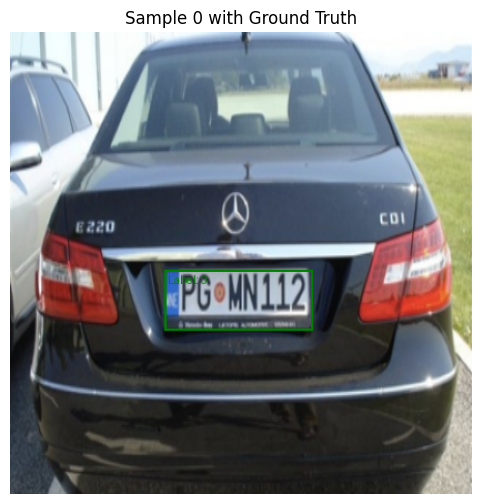

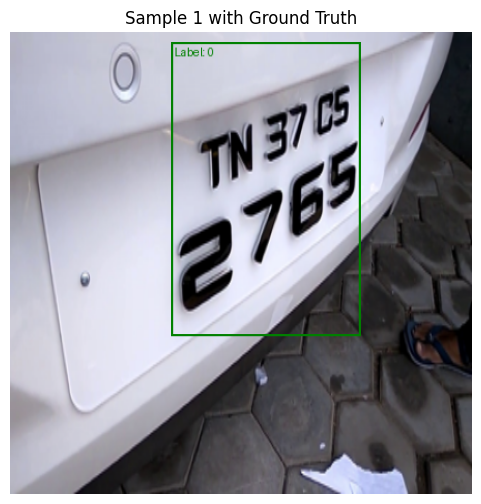

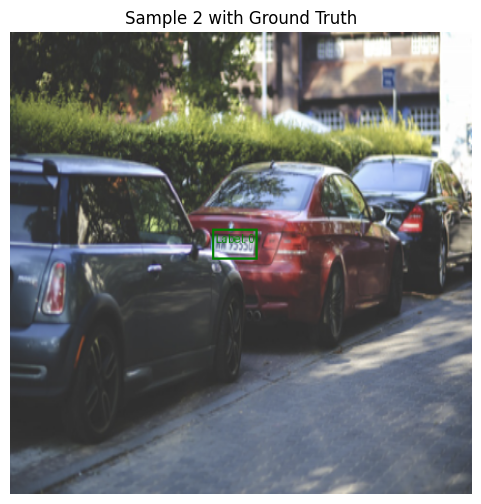

In [35]:
## testing with training data


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 416
TRAIN_IMG_DIR = "/content/drive/MyDrive/Number_Plate/dataset/train/images"
TRAIN_LABEL_DIR = "/content/drive/MyDrive/Number_Plate/dataset/train/labels"


dataset = YOLODataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, img_size=(IMAGE_SIZE, IMAGE_SIZE), augment=False)


N = 3
for idx in range(N):
    image_tensor, targets = dataset[idx]
    _, H, W = image_tensor.shape

    boxes = []
    labels = []
    for obj in targets:
        class_id, x_c, y_c, w, h = obj.tolist()
        x1 = (x_c - w / 2) * W
        y1 = (y_c - h / 2) * H
        x2 = (x_c + w / 2) * W
        y2 = (y_c + h / 2) * H
        boxes.append([x1, y1, x2, y2])
        labels.append(f"Label: {int(class_id)}")

    boxes_tensor = torch.tensor(boxes).float()
    image_with_boxes = draw_bounding_boxes(
        (image_tensor * 255).byte(),
        boxes=boxes_tensor,
        labels=labels,
        colors="green",
        width=2
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(TF.to_pil_image(image_with_boxes))
    plt.title(f"Sample {idx} with Ground Truth")
    plt.axis("off")
    plt.show()